## <center>CIFAR Code Along with CNN </center>
The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).<br>
Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

c:\Users\Lenovo\anaconda3\envs\pytorchenv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


### Data exploration

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='C:/Users/Lenovo/Desktop/Python/Neural Networks/Data Sets', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='C:/Users/Lenovo/Desktop/Python/Neural Networks/Data Sets', train=False, download=True, transform=transform)

Using downloaded and verified file: C:/Users/Lenovo/Desktop/Python/Neural Networks/Data Sets\cifar-10-python.tar.gz
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: C:/Users/Lenovo/Desktop/Python/Neural Networks/Data Sets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Users/Lenovo/Desktop/Python/Neural Networks/Data Sets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

#### Define strings for labels
We can call the labels whatever we want, so long as they appear in the order of 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. Here we're using 5-character labels padded with spaces so that our reports line up later.

In [6]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [    3     2     0     4     9     5     1     2     4     8]
Class:    cat  bird plane  deer truck   dog   car  bird  deer  ship


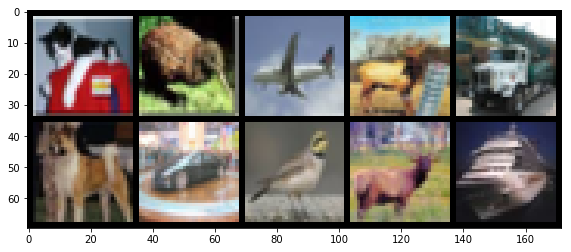

In [7]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Define the model
In the previous section we used two convolutional layers and two pooling layers before feeding data through a fully connected hidden layer to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC. We'll use the same format here.

The only changes are:
* take in 3-channel images instead of 1-channel
* adjust the size of the fully connected input<br>

Our first convolutional layer will have 3 input channels, 6 output channels, a kernel size of 3 (resulting in a 3x3 filter), and a stride length of 1 pixel.<br>These are passed in as <tt>nn.Conv2d(3,6,3,1)</tt>

In [8]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (5*5*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

<div class="alert alert-info"><strong>Why <tt>(6x6x16)</tt> instead of <tt>(5x5x16)</tt>?</strong><br>
With MNIST the kernels and pooling layers resulted in (((28−2)/2)−2)/2=5.5 which rounds down to 5 pixels per side.<br>
With CIFAR the result is (((32-2)/2)-2)/2 = 6.5 which rounds down to 6 pixels per side.</div>

In [9]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad(3\times6\times3\times3)+6+(6\times16\times3\times3)+16+(576\times120)+120+(120\times84)+84+(84\times10)+10 =\\
162+6+864+16+69120+120+10080+84+840+10 = 81,302$<br>

### Train the model
This time we'll feed the data directly into the model without flattening it first.<br>

In [10]:
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.66352153  accuracy:  26.940%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.89650190  accuracy:  33.080%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.88528514  accuracy:  36.793%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.36859000  accuracy:  39.035%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.40963387  accuracy:  41.064%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.28223443  accuracy:  51.320%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.25306702  accuracy:  51.540%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.20396245  accuracy:  51.877%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.18823016  accuracy:  52.318%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 2.17450285  accuracy:  52.788%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.31580102  accuracy:  56.440%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.45265329  accuracy:  56.790%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 0.83824605  accuracy:  57.127%
epoch:  2  b

## Plot the loss and accuracy comparisons

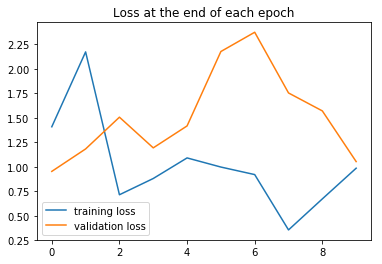

In [11]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

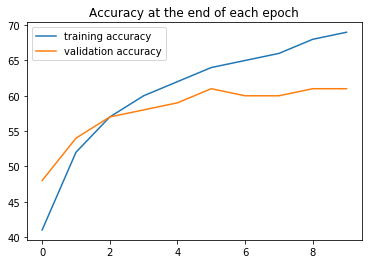

In [12]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [13]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4835), tensor(5483), tensor(5768), tensor(5843), tensor(5928), tensor(6175), tensor(6019), tensor(6078), tensor(6184), tensor(6124)]

Test accuracy: 61.240%


This is not as impressive as with MNIST, which makes sense. We would have to adjust our parameters to obtain better results.<br>
Still, it's much better than the 10% we'd get with random chance!

## Display the confusion matrix
In order to map predictions against ground truth, we need to run the entire test set through the model.<br>
Also, since our model was not as accurate as with MNIST, we'll use a <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>heatmap</a> to better display the results.

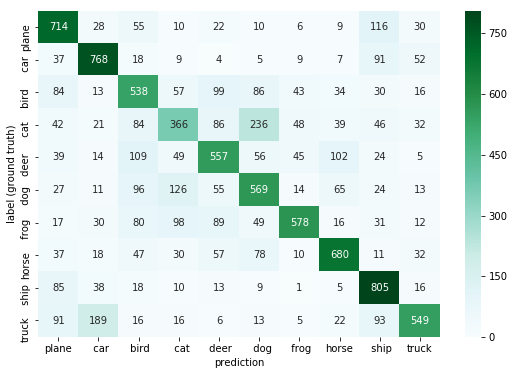

In [14]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();